# <center> Analyse de la concentration de CO2, <center>

In [135]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"    
# ‘all’|’last’|’last_expr’|’none’
#https://jupyter-console.readthedocs.io/en/4.0.1/config_options.html
pd.options.display.max_rows = 10

Nous récupérons les données les plus récentes sur le site en pointant sur un fichier au format .csv, si cette récupération est possible nous enregistrons une copie de ce fichier. Si pour une raison quelconque nous n'arrivons pas a faire ce téléchargement, nous travaillons sur le dernières données téléchargé.

In [136]:
try:
    raw_data = pd.read_csv("https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/"
                           "in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv",skiprows=56)
except OSError as err:
    print("Erreur lors du téléchargement : {0}".format(err))
    print("Nous téléchargeons les dernières données enregistrer sur notre PC")
    raw_data = pd.read_csv("monthly_in_situ_co2_mlo")
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise
else:
    raw_data.to_csv('monthly_in_situ_co2_mlo',index=True)

print(raw_data.shape)
raw_data.head()

(756, 10)


Excel                 [ppm]      [ppm]         [ppm]  \
0  1958    1     21200   1958.0411    -99.99      -99.99       -99.99   
1  1958    2     21231   1958.1260    -99.99      -99.99       -99.99   
2  1958    3     21259   1958.2027    315.70      314.44       316.19   
3  1958    4     21290   1958.2877    317.45      315.16       317.30   
4  1958    5     21320   1958.3699    317.51      314.71       317.86   

       [ppm]         [ppm]      [ppm].1  
0     -99.99        -99.99       -99.99  
1     -99.99        -99.99       -99.99  
2     314.91        315.70       314.44  
3     314.99        317.45       315.16  
4     315.06        317.51       314.71

Nous voyons que les noms des colonnes ne sont pas très représentatives, nous modifions  les noms des colonnes

In [137]:
raw_data_1 = raw_data.copy()
print(raw_data.columns)
raw_data_1.columns = ['Yr','Mn','Date 1','Date 2','s1','s2','s3','s4','s5','s6']

Index(['    ', '   ', '   Excel', '          ', '   [ppm]', '    [ppm] ',
       '      [ppm]', '    [ppm]', '       [ppm]', '    [ppm].1'],
      dtype='object')


In [138]:
raw_data_1.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
0  1958   1   21200  1958.0411  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
1  1958   2   21231  1958.1260  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71

Les données vide sont représentés par la valeur -99.99, nous remplaçons cette valeur par une valeur plus adéquate NaN dans une autre DataFrame

In [139]:
date = datetime.date.today()
data = raw_data_1.copy()
data = data.drop(data[(data.Yr == date.year) & (data.Mn > date.month)].index)
data = data.replace(-99.99,np.NaN);
d = data[(data.Yr == date.year)].index
i,k = d[0], d[-1]

while k>=i:
    if data.loc[k].isnull().any():
        data = data.drop(k)
    else:
        break
    k = k - 1
    
annee, mois  = data.Yr[0], data.Mn[0]
d = data[(data.Yr == annee)].index
i,k = d[0], d[-1]

while i<=k:
    if data.loc[i].isnull().any():
        data = data.drop(i)
    else:
        break
    i = i + 1
InteractiveShell.ast_node_interactivity = "all"     
data.head(3)
data.tail(3)
InteractiveShell.ast_node_interactivity = "last_expr"  

On visualise les lignes dont une donnée colonne est manquante.

In [140]:
data[data.isnull().any(axis=1)]

Yr  Mn  Date 1     Date 2  s1  s2      s3      s4      s5      s6
5   1958   6   21351  1958.4548 NaN NaN  317.24  315.14  317.24  315.14
9   1958  10   21473  1958.7890 NaN NaN  312.44  315.40  312.44  315.40
73  1964   2   23422  1964.1257 NaN NaN  320.01  319.36  320.01  319.36
74  1964   3   23451  1964.2049 NaN NaN  320.74  319.41  320.74  319.41
75  1964   4   23482  1964.2896 NaN NaN  321.83  319.45  321.83  319.45

In [141]:
data.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71
5  1958   6   21351  1958.4548     NaN     NaN  317.24  315.14  317.24  315.14
6  1958   7   21381  1958.5370  315.86  315.19  315.86  315.22  315.86  315.19

On ajoute un index 'périod' à la DataFrame, cet index représente la période de mesure. 
Cette date est mise dans au format compréhensible par pandas. On visualise toutes les lignes qui seront supprimées.

In [146]:
data = data.dropna().copy()
period = [datetime.date(y,m,1) for y,m in zip(data['Yr'],data['Mn'])]
period = pd.Series(period)
newdf = pd.concat([data,period],axis=1)
print(newdf.shape)
#data['period'] = pd.Series([datetime.date(y,m,1) for y,m in zip(data['Yr'],data['Mn'])])

#data1 = data1.set_index('period')   
#data
newdf

(745, 11)


Yr    Mn   Date 1     Date 2      s1      s2      s3      s4      s5  \
0       NaN   NaN      NaN        NaN     NaN     NaN     NaN     NaN     NaN   
1       NaN   NaN      NaN        NaN     NaN     NaN     NaN     NaN     NaN   
2    1958.0   3.0  21259.0  1958.2027  315.70  314.44  316.19  314.91  315.70   
3    1958.0   4.0  21290.0  1958.2877  317.45  315.16  317.30  314.99  317.45   
4    1958.0   5.0  21320.0  1958.3699  317.51  314.71  317.86  315.06  317.51   
..      ...   ...      ...        ...     ...     ...     ...     ...     ...   
740  2019.0   9.0  43723.0  2019.7068  408.55  412.06  408.52  412.05  408.55   
741  2019.0  10.0  43753.0  2019.7890  408.43  412.07  408.67  412.29  408.43   
742  2019.0  11.0  43784.0  2019.8740  410.28  412.56  410.29  412.54  410.28   
743  2019.0  12.0  43814.0  2019.9562  411.85  412.78  411.88  412.79  411.85   
744  2020.0   1.0  43845.0  2020.0410  413.37  413.33  413.11  413.05  413.37   

         s6           0  
0       NaN  1958-03-01  
1       NaN  1958-04-01  
2    314.44  1958-05-01  
3    315.16  1958-07-01  
4    314.71  1958-08-01  
..      ...         ...  
740  412.06         NaN  
741  412.07         NaN  
742  412.56         NaN  
743  412.78         NaN  
744  413.33         NaN  

[745 rows x 11 columns]

Représentation graphique de la concentration  de CO2 de 1958 à nos jours

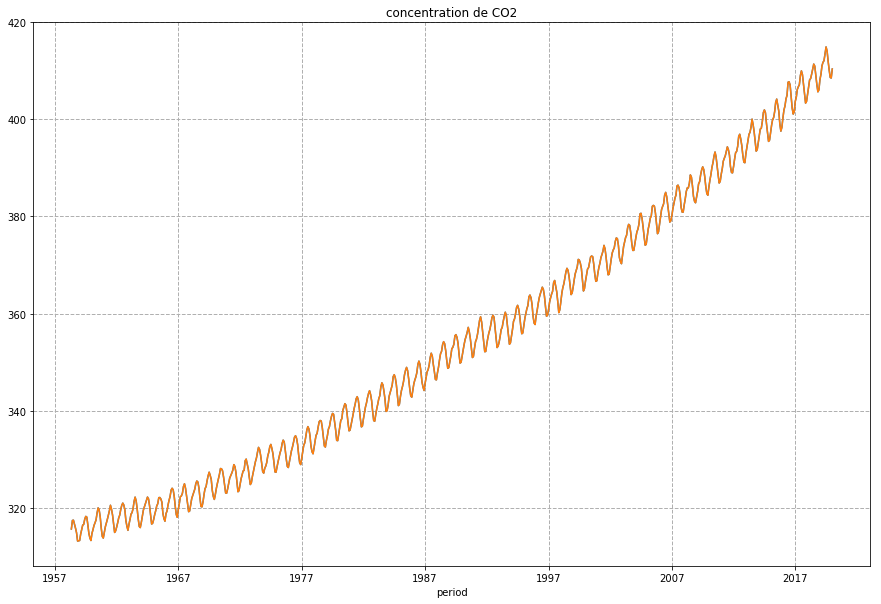

In [46]:
data1['s1'].plot(title = 'concentration de CO2',);
data1['s1'].plot(figsize=(15, 10),).grid(linestyle='--', linewidth=1);

Nous allons approximé la concentration de CO2 avec une droite, puis faire la différence pour 
n'obtenir que les variations de la concentration de CO2.

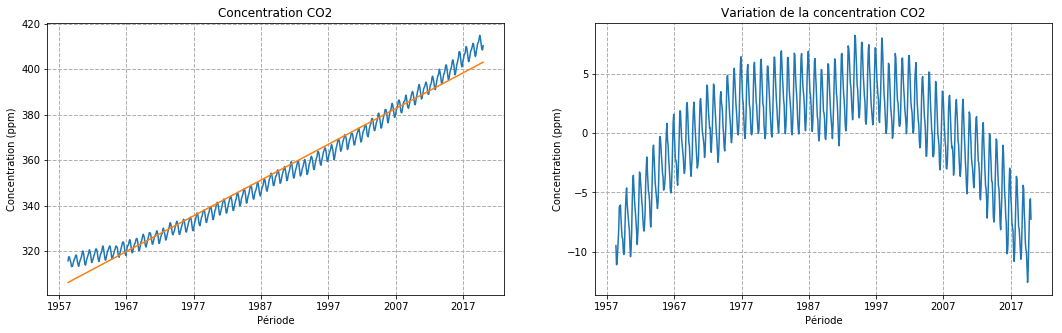

In [47]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(data1['Date 2'], data1['s1'])
def predict(x):
    return slope*x+intercept

data_lineaire = data1.copy()
data_lineaire['reg_lineaire'] = predict(data_lineaire['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
#plot(figsize=(8, 5))  .plot(figsize=(15, 10), grid=True).grid(linestyle='--', linewidth=1);

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_lineaire['s1'])
#data1['s1'].plot()
ax1.plot(data_lineaire['reg_lineaire']) 
data_lineaire['co2'] = data_lineaire['reg_lineaire']-data_lineaire['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_lineaire['co2']); 

Le résultat n'est pas satisfaisant ...
Nous pouvons faire une optimisation avec une fonction de la forme $a*(x-b)^2+c$

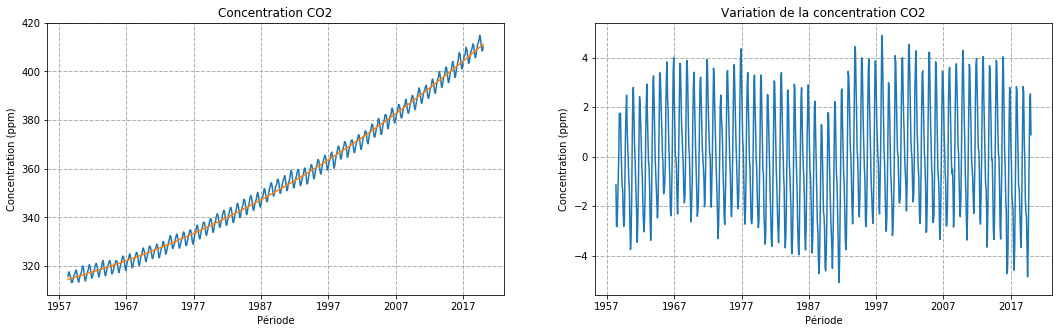

In [48]:
from scipy.optimize import curve_fit

def func(x,a,b,c):
    return a*(x-b)**(2)+c

data_cube = data1.copy()

x = data_cube['Date 2']
y = data_cube['s1']
popt, pcov = curve_fit(func,x,y)

def fa(x):
    return popt[0]*(x- popt[1])**(2)+popt[2]

data_cube['reg_cube'] = fa(data_cube['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_cube['s1'])
ax1.plot(data_cube['reg_cube']) 
data_cube['co2'] = data_cube['reg_cube']-data_cube['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_cube['co2']); 

Nous recherchons l'oscillation lente, pour cela nous allons opéré en 2 etapes :
- Recherche de la fréquence lente, par FFT. Pour cela nous devons faire une interpolation pour les quelque points manquant. Ce qui nous donnera une gamme de fréquence possible (échantillonne de la FFT)
- Pour la gamme de fréquence spécifiées, nous  estimons tous les paramètres pour une approximation sinusoïdale (moyenne, amplitude et phase) par les moindres carrés ordinaires 


In [49]:
data2 = data.copy()

data2['period'] = pd.Series([datetime.date(y,m,1) for y,m in zip(data2['Yr'],data2['Mn'])])
data2 = data2.set_index('period')   
data2.head()
d = data2[data2.isnull().any(axis=1)]
d

Yr  Mn  Date 1     Date 2  s1  s2      s3      s4      s5  \
period                                                                    
1958-08-01  1958   6   21351  1958.4548 NaN NaN  317.24  315.14  317.24   
1958-12-01  1958  10   21473  1958.7890 NaN NaN  312.44  315.40  312.44   
1964-04-01  1964   2   23422  1964.1257 NaN NaN  320.01  319.36  320.01   
1964-05-01  1964   3   23451  1964.2049 NaN NaN  320.74  319.41  320.74   
1964-06-01  1964   4   23482  1964.2896 NaN NaN  321.83  319.45  321.83   

                s6  
period              
1958-08-01  315.14  
1958-12-01  315.40  
1964-04-01  319.36  
1964-05-01  319.41  
1964-06-01  319.45

In [70]:
data2 = data2.interpolate(method='linear', limit_direction='forward',limit=3)
data2

Yr  Mn  Date 1     Date 2       s1      s2      s3      s4  \
period                                                                     
1958-05-01  1958   3   21259  1958.2027  315.700  314.44  316.19  314.91   
1958-06-01  1958   4   21290  1958.2877  317.450  315.16  317.30  314.99   
1958-07-01  1958   5   21320  1958.3699  317.510  314.71  317.86  315.06   
1958-08-01  1958   6   21351  1958.4548  316.685  314.95  317.24  315.14   
1958-09-01  1958   7   21381  1958.5370  315.860  315.19  315.86  315.22   
1958-10-01  1958   8   21412  1958.6219  314.930  316.19  314.00  315.29   
1958-11-01  1958   9   21443  1958.7068  313.210  316.08  312.46  315.35   
1958-12-01  1958  10   21473  1958.7890  313.270  315.64  312.44  315.40   
1959-01-01  1958  11   21504  1958.8740  313.330  315.20  313.62  315.46   
1959-02-01  1958  12   21534  1958.9562  314.670  315.43  314.77  315.51   
1959-03-01  1959   1   21565  1959.0411  315.580  315.54  315.62  315.57   
1959-04-01  1959   2   21596  1959.1260  316.490  315.86  316.27  315.63   
1959-05-01  1959   3   21624  1959.2027  316.650  315.38  316.98  315.69   
1959-06-01  1959   4   21655  1959.2877  317.720  315.42  318.09  315.77   
1959-07-01  1959   5   21685  1959.3699  318.290  315.49  318.65  315.85   
1959-08-01  1959   6   21716  1959.4548  318.150  316.03  318.04  315.94   
1959-09-01  1959   7   21746  1959.5370  316.540  315.86  316.67  316.03   
1959-10-01  1959   8   21777  1959.6219  314.800  316.06  314.83  316.12   
1959-11-01  1959   9   21808  1959.7068  313.840  316.72  313.32  316.22   
1959-12-01  1959  10   21838  1959.7890  313.330  316.32  313.33  316.30   
1960-01-01  1959  11   21869  1959.8740  314.810  316.68  314.54  316.39   
1960-02-01  1959  12   21899  1959.9562  315.580  316.35  315.72  316.47   
1960-03-01  1960   1   21930  1960.0410  316.430  316.39  316.61  316.56   
1960-04-01  1960   2   21961  1960.1257  316.980  316.35  317.27  316.64   
1960-05-01  1960   3   21990  1960.2049  317.580  316.28  318.03  316.71   
1960-06-01  1960   4   22021  1960.2896  319.030  316.70  319.14  316.79   
1960-07-01  1960   5   22051  1960.3716  320.040  317.22  319.67  316.86   
1960-08-01  1960   6   22082  1960.4563  319.590  317.48  319.01  316.93   
1960-09-01  1960   7   22112  1960.5383  318.180  317.53  317.60  316.98   
1960-10-01  1960   8   22143  1960.6230  315.900  317.20  315.69  317.01   
...          ...  ..     ...        ...      ...     ...     ...     ...   
2017-10-01  2017   8   42962  2017.6219  405.240  406.77  405.20  406.76   
2017-11-01  2017   9   42993  2017.7068  403.270  406.76  403.41  406.92   
2017-12-01  2017  10   43023  2017.7890  403.640  407.25  403.47  407.07   
2018-01-01  2017  11   43054  2017.8740  405.170  407.43  404.98  407.22   
2018-02-01  2017  12   43084  2017.9562  406.750  407.68  406.46  407.37   
2018-03-01  2018   1   43115  2018.0411  408.050  408.00  407.58  407.52   
2018-04-01  2018   2   43146  2018.1260  408.340  407.59  408.44  407.68   
2018-05-01  2018   3   43174  2018.2027  409.250  407.71  409.39  407.82   
2018-06-01  2018   4   43205  2018.2877  410.300  407.51  410.82  408.00   
2018-07-01  2018   5   43235  2018.3699  411.300  407.90  411.60  408.20   
2018-08-01  2018   6   43266  2018.4548  410.880  408.30  410.97  408.42   
2018-09-01  2018   7   43296  2018.5370  408.900  408.08  409.43  408.65   
2018-10-01  2018   8   43327  2018.6219  407.100  408.63  407.33  408.91   
2018-11-01  2018   9   43358  2018.7068  405.590  409.09  405.66  409.18   
2018-12-01  2018  10   43388  2018.7890  405.990  409.62  405.83  409.44   
2019-01-01  2018  11   43419  2018.8740  408.120  410.39  407.47  409.72   
2019-02-01  2018  12   43449  2018.9562  409.230  410.16  409.07  409.97   
2019-03-01  2019   1   43480  2019.0411  410.920  410.87  410.29  410.23   
2019-04-01  2019   2   43511  2019.1260  411.660  410.90  411.24  410.47   
2019-05-01  2019   3   43539  2019.2027  412.000  410.45  412.

In [72]:
data2 = data2[(data2.Yr >= 1964) & (data2.Yr < 1965)]
data2

Yr  Mn  Date 1     Date 2        s1        s2      s3      s4  \
period                                                                        
1964-03-01  1964   1   23391  1964.0410  319.5700  319.5300  319.37  319.32   
1964-04-01  1964   2   23422  1964.1257  320.2425  319.4975  320.01  319.36   
1964-05-01  1964   3   23451  1964.2049  320.9150  319.4650  320.74  319.41   
1964-06-01  1964   4   23482  1964.2896  321.5875  319.4325  321.83  319.45   
1964-07-01  1964   5   23512  1964.3716  322.2600  319.4000  322.34  319.49   
1964-08-01  1964   6   23543  1964.4563  321.8900  319.7500  321.64  319.52   
1964-09-01  1964   7   23573  1964.5383  320.4400  319.7800  320.19  319.55   
1964-10-01  1964   8   23604  1964.6230  318.6900  320.0000  318.24  319.58   
1964-11-01  1964   9   23635  1964.7077  316.7100  319.6500  316.64  319.60   
1964-12-01  1964  10   23665  1964.7896  316.8700  319.9100  316.59  319.62   
1965-01-01  1964  11   23696  1964.8743  317.6800  319.5800  317.76  319.64   
1965-02-01  1964  12   23726  1964.9563  318.7100  319.4900  318.89  319.66   

                s5      s6  
period                      
1964-03-01  319.57  319.53  
1964-04-01  320.01  319.36  
1964-05-01  320.74  319.41  
1964-06-01  321.83  319.45  
1964-07-01  322.26  319.40  
1964-08-01  321.89  319.75  
1964-09-01  320.44  319.78  
1964-10-01  318.69  320.00  
1964-11-01  316.71  319.65  
1964-12-01  316.87  319.91  
1965-01-01  317.68  319.58  
1965-02-01  318.71  319.49